<a href="https://colab.research.google.com/github/elsabrunetratnasingham/notes/blob/main/Elsa_scVIwEduardo_1013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to scvi-tools
In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

     |████████████████████████████████| 237 kB 16.2 MB/s 
     |████████████████████████████████| 51 kB 3.1 MB/s 
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

* Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input. 

</div>

In [13]:
import pandas as pd
import anndata
adata=anndata.read_mtx("matrix.mtx.gz")
adata = adata.T
adata

AnnData object with n_obs × n_vars = 3367 × 36601

In [9]:
obs = pd.read_csv("barcodes.tsv.gz", sep = "\t", header = None)
obs.columns = ["barcode"]
obs

,barcode
0,AAACCCACATGAAGGC-1
1,AAACCCAGTTAAGGAT-1
2,AAACCCAGTTCGTAAC-1
3,AAACCCATCGCATTAG-1
4,AAACGAAAGAAGCTGC-1
...,...
3362,TTTGGAGGTCTGCGCA-1
3363,TTTGGAGTCCCAGGAC-1
3364,TTTGGTTCACCCTAGG-1
3365,TTTGTTGAGGTCCTGC-1


In [20]:
var = pd.read_csv("features.tsv.gz", sep = "\t", header = None)
var.columns = ["gene_id", "gene_name", "Feature"]
var.index = var.gene_name
var

,gene_id,gene_name,Feature
gene_name,,,
MIR1302-2HG,ENSG00000243485,MIR1302-2HG,Gene Expression
FAM138A,ENSG00000237613,FAM138A,Gene Expression
OR4F5,ENSG00000186092,OR4F5,Gene Expression
AL627309.1,ENSG00000238009,AL627309.1,Gene Expression
AL627309.3,ENSG00000239945,AL627309.3,Gene Expression
...,...,...,...
AC141272.1,ENSG00000277836,AC141272.1,Gene Expression
AC023491.2,ENSG00000278633,AC023491.2,Gene Expression
AC007325.1,ENSG00000276017,AC007325.1,Gene Expression


In [21]:
adata.var =var
adata.obs = obs
adata


AnnData object with n_obs × n_vars = 3367 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name', 'Feature'

In [60]:
duplicates = list(adata.var.gene_name.value_counts()[adata.var.gene_name.value_counts()>1].index.values)
unique_gene_names=[]
for idx, gene in enumerate(adata.var.gene_name.values):
    if gene in duplicates:
        unique_name= adata.var.index[idx]
    else:
        unique_name=gene
    unique_gene_names.append(unique_name)

print(len(unique_gene_names))
adata.var['unique_gene_names']=unique_gene_names
adata.var.index=adata.var['unique_gene_names'].values
adata

1200


AnnData object with n_obs × n_vars = 3367 × 1200
    obs: 'barcode', '_scvi_batch', '_scvi_labels', 'leiden_scVI', '_scvi_raw_norm_scaling', 'cell_type'
    var: 'gene_id', 'gene_name', 'Feature', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'unique_gene_names'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors', 'dendrogram_cell_type'
    obsm: 'X_scVI', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [14]:
boom = scvi.data.heart_cell_atlas_subsampled()
boom


INFO     Downloading file at data/hca_subsampled_20k.h5ad                                                          
Downloading...: 100%|██████████| 65714/65714.0 [00:00<00:00, 102400.93it/s]


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [16]:
boom.obs

,NRP,age_group,cell_source,cell_type,donor,gender,n_counts,n_genes,percent_mito,percent_ribo,region,sample,scrublet_score,source,type,version,cell_states,Used
AACTCCCCACGAGAGT-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Myeloid,D6,Male,1420.0,738,0.054930,0.064789,LA,HCAHeart7844001,0.113475,CD45+,DCD,V2,LYVE1+MØ1,Yes
ATAACGCAGAGCTGGT-1-HCAHeart7829979,No,70-75,Sanger-Nuclei,Ventricular_Cardiomyocyte,D4,Female,844.0,505,0.001185,0.001185,RV,HCAHeart7829979,0.085546,Nuclei,DCD,V2,vCM1,Yes
GTCAAGTCATGCCACG-1-HCAHeart7702879,Yes,60-65,Sanger-Nuclei,Fibroblast,D2,Male,1491.0,862,0.000000,0.005366,RA,HCAHeart7702879,0.197861,Nuclei,DCD,V2,FB2,Yes
GGTGATTCAAATGAGT-1-HCAHeart8102858,Yes,60-65,Sanger-CD45,Endothelial,D11,Female,2167.0,1115,0.064144,0.027227,LA,HCAHeart8102858,0.113475,CD45+,DCD,V3,EC10_CMC-like,Yes
AGAGAATTCTTAGCAG-1-HCAHeart8102863,Yes,60-65,Sanger-Cells,Endothelial,D11,Female,7334.0,2505,0.093537,0.040496,RA,HCAHeart8102863,0.132150,Cells,DCD,V3,EC5_art,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGTCAGGCAAGGCTCC-1-HCAHeart7985087,No,55-60,Sanger-Nuclei,Ventricular_Cardiomyocyte,D3,Male,4478.0,2243,0.002233,0.001340,RV,HCAHeart7985087,0.185751,Nuclei,DBD,V2,vCM1,Yes
AGTCACAAGACGAGCT-1-H0035_RV,No,45-50,Harvard-Nuclei,Pericytes,H7,Female,967.0,630,0.002068,0.004137,RV,H0035_RV,0.081779,Nuclei,DBD,V3,PC1_vent,Yes
GGTGAAGGTTCCACAA-1-HCAHeart7844001,Yes,65-70,Sanger-CD45,Lymphoid,D6,Male,1599.0,619,0.041901,0.155722,LA,HCAHeart7844001,0.074830,CD45+,DCD,V2,CD4+T_tem,Yes
CAGCTAAGTACAGACG-1-HCAHeart7702876,Yes,60-65,Sanger-Nuclei,Atrial_Cardiomyocyte,D2,Male,3715.0,1523,0.000269,0.002423,LA,HCAHeart7702876,0.048649,Nuclei,DCD,V2,aCM3,Yes


In [61]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

<div class="alert alert-info">

Important

Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

</div>

In [62]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [63]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=5000, 
    subset=True, 
    layer="counts", 
    flavor="seurat_v3",
    # batch_key="cell_source"
)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [64]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    # categorical_covariate_keys=["cell_source", "donor"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

/usr/local/lib/python3.8/dist-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [65]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [66]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

<div class="alert alert-info">
Important

All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.

</div>

In [67]:
model.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [01:52<00:00,  3.60it/s, loss=209, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:52<00:00,  3.56it/s, loss=209, v_num=1]


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [68]:
# model.save("my_model/")

In [69]:
# model = scvi.model.SCVI.load("my_model/", adata=adata, use_gpu=True)

## Obtaining model outputs

In [70]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [72]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [ ]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                              


INFO:scvi.model.base._base_model:Received view of anndata, making copy.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


INFO:scvi.model.base._base_model:Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


In [ ]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

INFO     Received view of anndata, making copy.                                              


INFO:scvi.model.base._base_model:Received view of anndata, making copy.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


INFO:scvi.model.base._base_model:Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.343808,0.118372,1.945633,0.062702,4.456603
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.552080,0.275485,1.457585,0.013442,14.617260
CCTCTGATCGTGACAT-1-HCAHeart7702881,5.157080,0.295140,1.195748,0.143792,2.908867
CGCCATTCATCATCTT-1-H0035_apex,0.352172,0.019281,0.570386,0.105633,6.325405
TCGTAGAGTAGGACTG-1-H0015_septum,0.290155,0.040910,0.400771,0.723409,8.142258


Let's store the normalized values back in the anndata.

In [73]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

<div class="alert alert-warning">

Warning

We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.

</div>

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [74]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

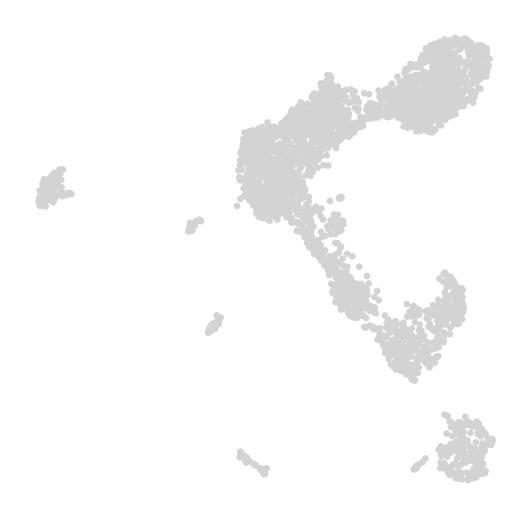

In [75]:
sc.pl.umap(
    adata, 
    #  c="red", 
    frameon=False,
)


We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [76]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

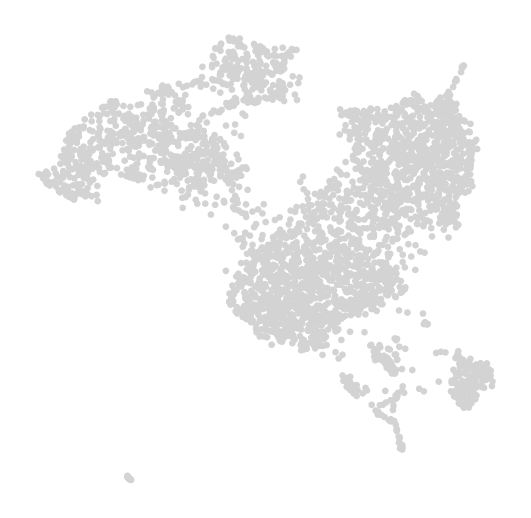

In [77]:
sc.pl.umap(
    adata, 
    # color=["cell_type"], 
    frameon=False,


)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

### Clustering on the scVI latent space

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [78]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

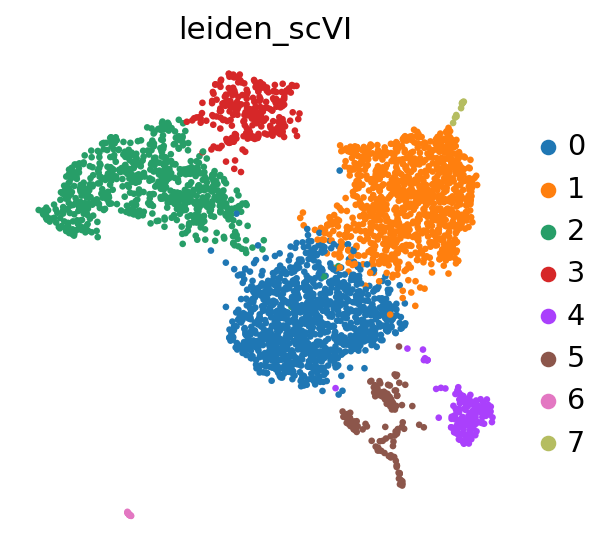

In [79]:
sc.pl.umap(
    adata, 
    color=["leiden_scVI"], 
    frameon=False,
)

## Differential expression
We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see the [API docs](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.differential_expression.html#scvi.model.SCVI.differential_expression).

In [ ]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

For example, a 1-vs-1 DE test is as simple as:

In [ ]:
de_df = model.differential_expression(
    groupby="cell_type", 
    group1="Endothelial", 
    group2="Fibroblast"
)
de_df.head()

DE...: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
SOX17,0.9998,0.0002,8.516943,0.001615,0.000029,0.0,0.25,6.222365,6.216846,1.967564,...,0.784371,0.006541,0.307617,0.004497,17.128170,0.185868,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
SLC9A3R2,0.9996,0.0004,7.823621,0.010660,0.000171,0.0,0.25,5.977907,6.049340,1.672150,...,4.451492,0.045380,0.712339,0.034342,111.582703,1.657324,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
ABCA10,0.9990,0.0010,6.906745,0.000081,0.006355,0.0,0.25,-8.468659,-9.058912,2.959383,...,0.014359,1.282508,0.007788,0.499591,0.501825,69.613876,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
EGFL7,0.9986,0.0014,6.569875,0.008471,0.000392,0.0,0.25,4.751251,4.730982,1.546327,...,2.376779,0.036795,0.741543,0.025756,89.507553,1.169474,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
VWF,0.9984,0.0016,6.436144,0.014278,0.000553,0.0,0.25,5.013347,5.029471,1.758744,...,5.072563,0.054375,0.808226,0.032298,169.693512,2.207696,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [80]:
adata

AnnData object with n_obs × n_vars = 3367 × 1167
    obs: 'barcode', '_scvi_batch', '_scvi_labels', 'leiden_scVI', '_scvi_raw_norm_scaling', 'cell_type'
    var: 'gene_id', 'gene_name', 'Feature', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'unique_gene_names'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'leiden', 'dendrogram_cell_type', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [81]:
de_df = model.differential_expression(
    groupby="leiden_scVI", 
)
de_df.head()

DE...: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
CDC45,0.9946,0.0054,5.215940,1.901144e-09,0.000012,0.0,0.25,-11.955602,-12.401503,8.014258,...,0.0,0.002447,0.0,0.006138,0.0,0.010127,True,0 vs Rest,0,Rest
CYP1B1,0.9924,0.0076,4.871977,3.865210e-07,0.000039,0.0,0.25,-9.884813,-10.102109,6.438966,...,0.0,0.009071,0.0,0.014906,0.0,0.130346,True,0 vs Rest,0,Rest
TYMS,0.9912,0.0088,4.724163,2.578460e-07,0.000034,0.0,0.25,-8.422282,-8.763905,5.677030,...,0.0,0.006961,0.0,0.018413,0.0,0.053562,True,0 vs Rest,0,Rest
FCAR,0.9910,0.0090,4.701489,4.095173e-08,0.000007,0.0,0.25,-8.748952,-8.873770,5.987713,...,0.0,0.001586,0.0,0.001754,0.0,0.009397,True,0 vs Rest,0,Rest
PROCR,0.9896,0.0104,4.555494,5.566119e-07,0.000062,0.0,0.25,-7.852795,-7.898144,5.244359,...,0.0,0.013145,0.0,0.026743,0.0,0.098384,True,0 vs Rest,0,Rest


In [85]:
cdf = de_df[de_df["group1"]=="3"]
cdf

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C22orf42,0.9876,0.0124,4.377580,0.000037,0.000006,0.0,0.25,7.758478,7.394350,5.607063,...,0.006091,0.001214,0.019084,0.001932,0.014738,0.019014,True,3 vs Rest,3,Rest
TRH,0.9874,0.0126,4.361378,0.000059,0.000010,0.0,0.25,8.276906,8.128851,5.879901,...,0.012575,0.001636,0.068702,0.003221,0.018303,0.003199,True,3 vs Rest,3,Rest
KRT14,0.9864,0.0136,4.283991,0.000027,0.000016,0.0,0.25,7.658707,7.754030,6.249977,...,0.007978,0.002791,0.038168,0.005153,0.014754,0.020036,True,3 vs Rest,3,Rest
CDC45,0.9856,0.0144,4.226022,0.000019,0.000007,0.0,0.25,10.454168,9.938116,8.450106,...,0.004306,0.001435,0.022901,0.002576,0.002242,0.007250,True,3 vs Rest,3,Rest
KRTAP3-1,0.9848,0.0152,4.171142,0.000033,0.000018,0.0,0.25,8.511553,9.065573,7.000183,...,0.013590,0.005148,0.038168,0.006119,0.012104,0.095782,True,3 vs Rest,3,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDC2,0.6702,0.3298,0.709090,0.019604,0.024767,0.0,0.25,-0.206248,-0.233408,0.721945,...,4.436985,3.241479,1.000000,0.971659,8.757031,180.658585,False,3 vs Rest,3,Rest
SLPI,0.6562,0.3438,0.646406,0.022014,0.028396,0.0,0.25,-0.245299,-0.253190,0.693426,...,5.038340,3.775117,1.000000,0.993559,9.776004,217.018646,False,3 vs Rest,3,Rest
TMSB4X,0.6326,0.3674,0.543387,0.009004,0.011342,0.0,0.25,-0.275622,-0.240748,0.513372,...,1.987169,1.658502,0.992366,0.711755,3.560907,72.455093,False,3 vs Rest,3,Rest
AGR2,0.5608,0.4392,0.244409,0.013535,0.013197,0.0,0.25,0.156761,-0.005122,0.791649,...,2.879035,1.863327,1.000000,0.759420,5.610478,80.731628,False,3 vs Rest,3,Rest


In [87]:
cdf[cdf["proba_not_de"]<0.02]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C22orf42,0.9876,0.0124,4.377580,0.000037,0.000006,0.0,0.25,7.758478,7.394350,5.607063,...,0.006091,0.001214,0.019084,0.001932,0.014738,0.019014,True,3 vs Rest,3,Rest
TRH,0.9874,0.0126,4.361378,0.000059,0.000010,0.0,0.25,8.276906,8.128851,5.879901,...,0.012575,0.001636,0.068702,0.003221,0.018303,0.003199,True,3 vs Rest,3,Rest
KRT14,0.9864,0.0136,4.283991,0.000027,0.000016,0.0,0.25,7.658707,7.754030,6.249977,...,0.007978,0.002791,0.038168,0.005153,0.014754,0.020036,True,3 vs Rest,3,Rest
CDC45,0.9856,0.0144,4.226022,0.000019,0.000007,0.0,0.25,10.454168,9.938116,8.450106,...,0.004306,0.001435,0.022901,0.002576,0.002242,0.007250,True,3 vs Rest,3,Rest
KRTAP3-1,0.9848,0.0152,4.171142,0.000033,0.000018,0.0,0.25,8.511553,9.065573,7.000183,...,0.013590,0.005148,0.038168,0.006119,0.012104,0.095782,True,3 vs Rest,3,Rest
PBK,0.9844,0.0156,4.144761,0.000015,0.000015,0.0,0.25,7.884646,7.538158,6.941511,...,0.003041,0.002118,0.022901,0.002899,0.001936,0.018989,True,3 vs Rest,3,Rest
TRHDE,0.9844,0.0156,4.144761,0.000012,0.000004,0.0,0.25,7.096784,6.742426,5.637062,...,0.003284,0.001893,0.007634,0.003221,0.002776,0.003141,True,3 vs Rest,3,Rest
KIR2DL4,0.9844,0.0156,4.144761,0.000013,0.000011,0.0,0.25,8.008968,7.401021,6.678444,...,0.000000,0.003894,0.000000,0.002254,0.000000,0.117656,True,3 vs Rest,3,Rest
MUC2,0.9838,0.0162,4.106411,0.000021,0.000008,0.0,0.25,6.911147,6.914775,5.824971,...,0.006786,0.002525,0.019084,0.002899,0.006193,0.004566,True,3 vs Rest,3,Rest
SRARP,0.9836,0.0164,4.093937,0.000116,0.000032,0.0,0.25,7.373231,7.306487,5.152461,...,0.029449,0.004045,0.118321,0.007729,0.048102,0.039202,True,3 vs Rest,3,Rest


We now extract top markers for each cluster using the DE results.

In [88]:
adata.obs["cell_type"]=adata.obs["leiden_scVI"]

In [95]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:5]

In [96]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

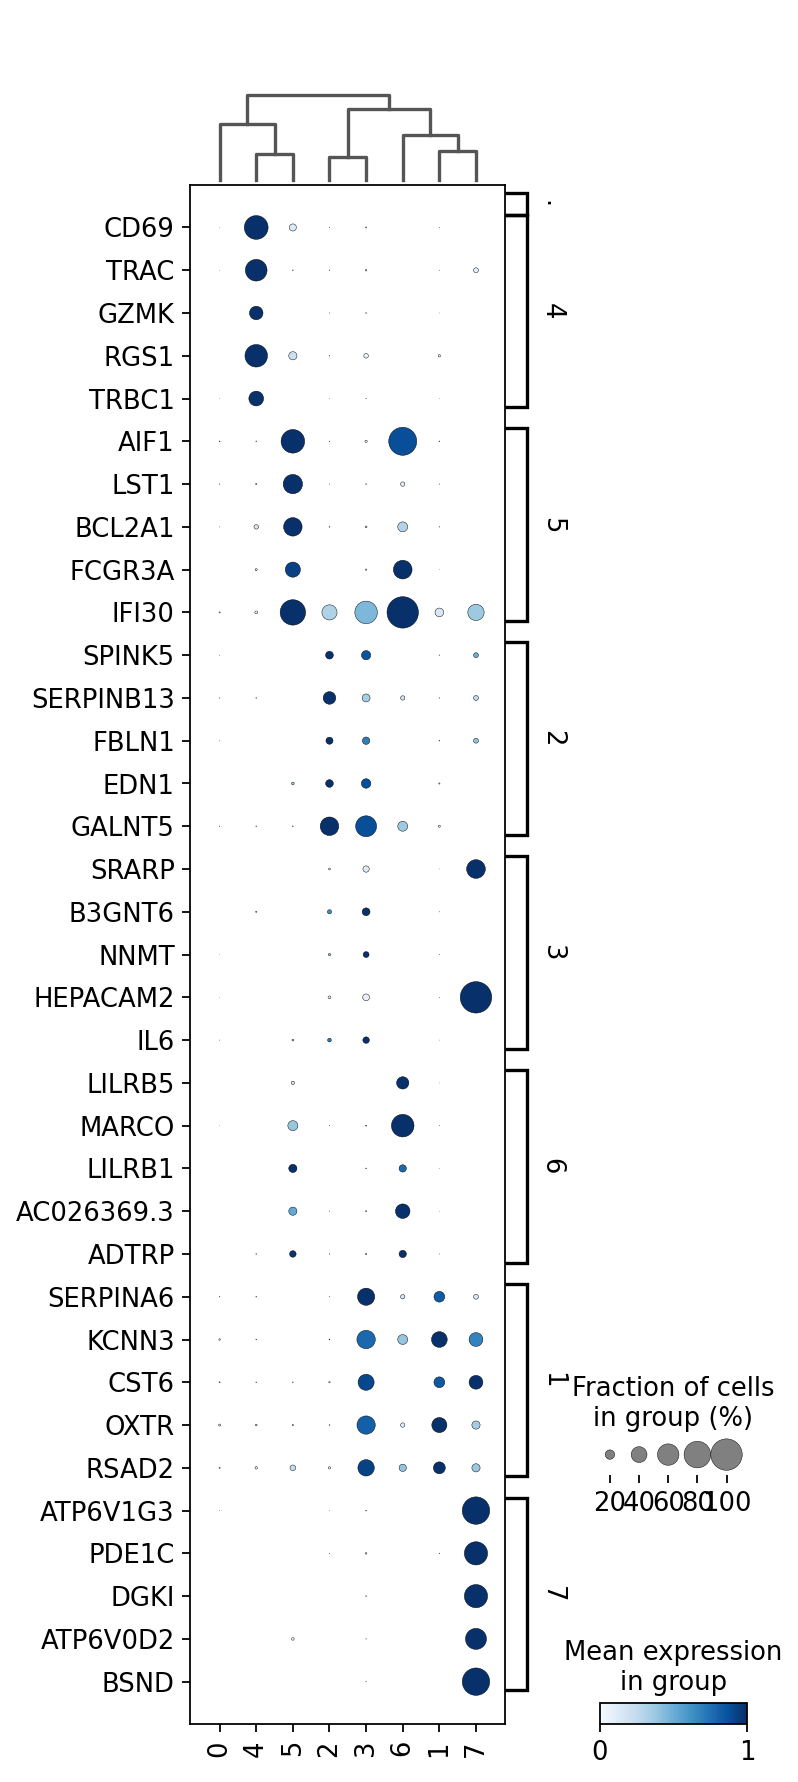

In [97]:
sc.pl.dotplot(
    adata, 
    markers, 
    groupby='cell_type', 
    dendrogram=True, 
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

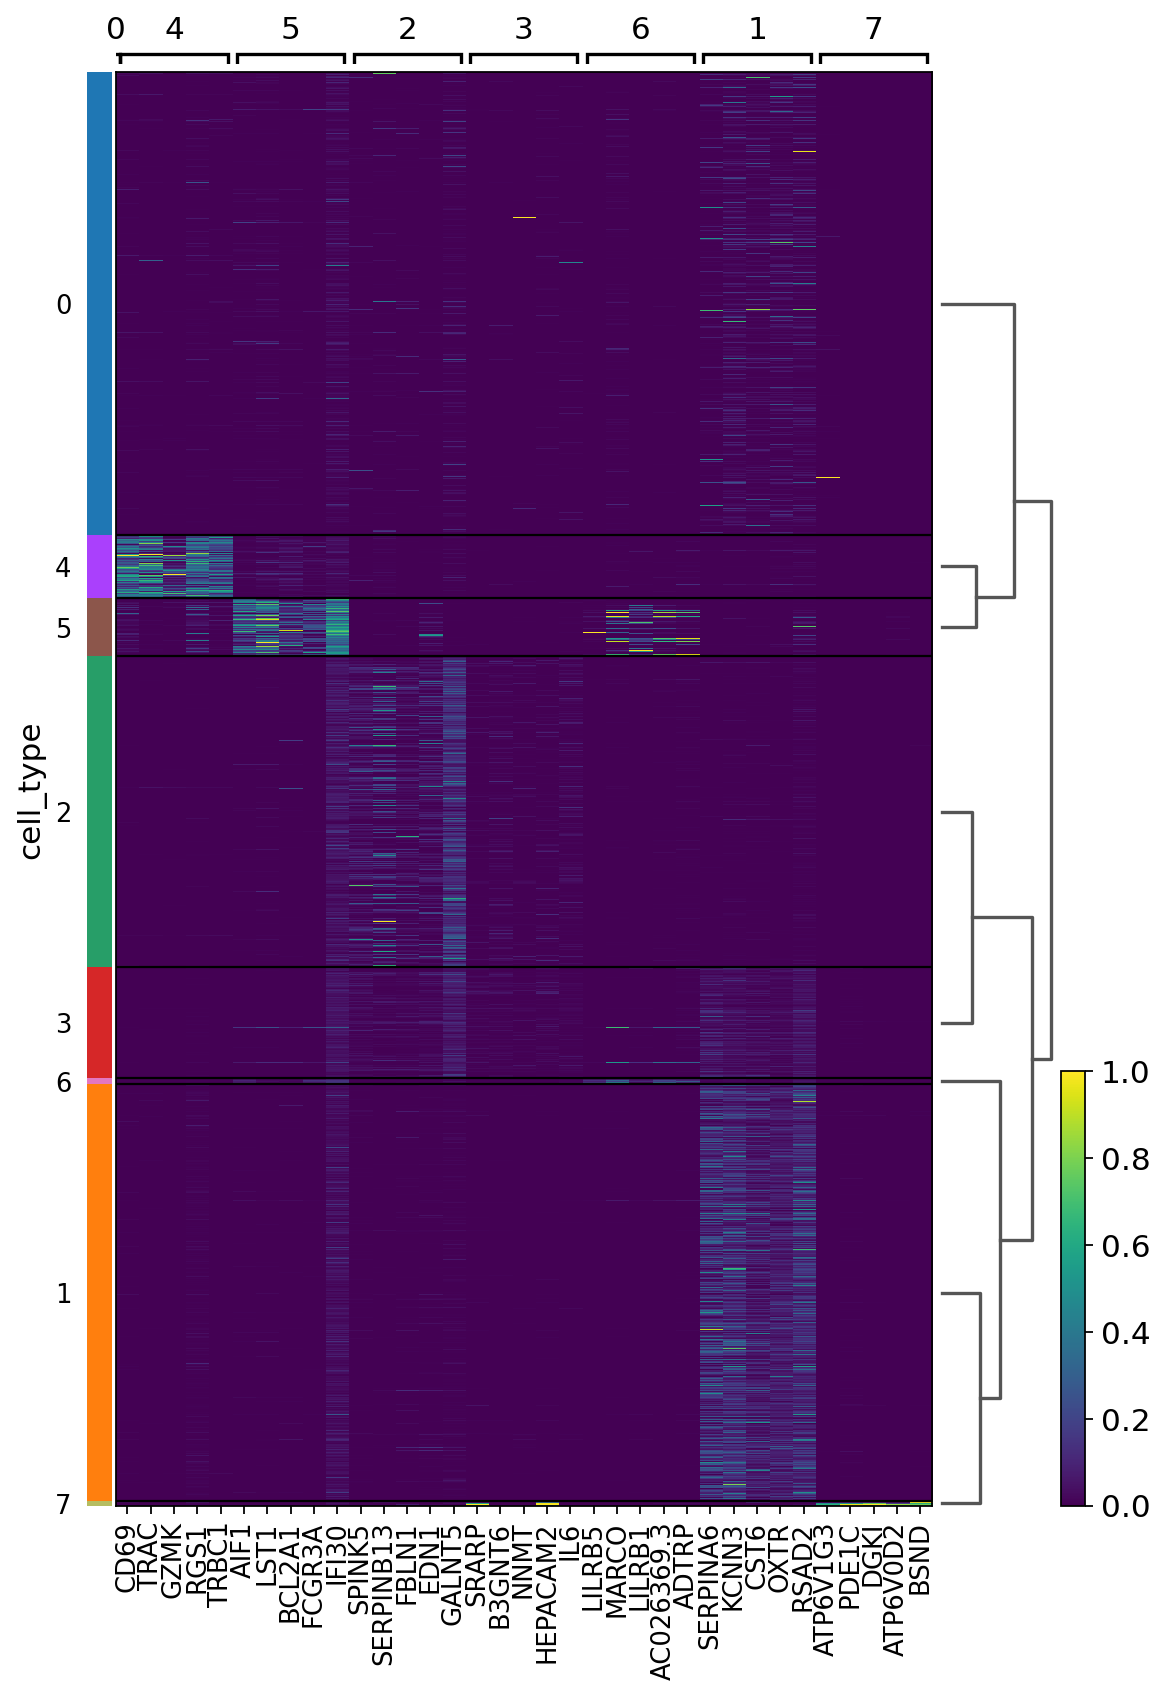

In [98]:
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

## Logging information

Verbosity varies in the following way:

* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>